In [1]:
import copy
import math
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def create_bar_plot(data, x_title, y_title):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    ax.hist(x=data, bins='auto', alpha=0.7, rwidth=0.85)
    ax.grid(False)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [4]:
#Separating data for each drug/cell

def get_pos_map(obj_list, test_df, col):
    pos_map = {obj:[] for obj in obj_list}
    for i, row in test_df.iterrows():
        pos_map[row[col]].append(i)
    return pos_map

In [5]:
#Arrange the obj_list in the descending order of variance

def sort_var(obj_list, var_list):
    var_map = {}
    for i, obj in enumerate(obj_list):
        var_map[obj] = var_list[i]
    return {obj:var for obj,var in sorted(var_map.items(), key=lambda item:item[1], reverse=True)}

In [6]:
def calc_stddev(obj_list, train_df, col):
    var_list = [0.0] * len(obj_list)
    pos_map = get_pos_map(obj_list, train_df, col)
    for i, obj in enumerate(obj_list):
        train_vals = np.take(train_df['auc'], pos_map[obj])
        var_list[i] = np.std(train_vals)
    return sort_var(obj_list, var_list)

In [7]:
def get_filtered_data(df, fraction):
    
    fig = 0

    df.sort_values(by='auc', inplace=True, ignore_index=True)
    
    data_size = len(df)
    class_size = int(data_size * fraction)
    sens_df = df.iloc[ : class_size]
    res_df = df.iloc[data_size - class_size : data_size]
    
    filtered_df = pd.concat([sens_df, res_df], axis=0, ignore_index=True)
    filtered_df = filtered_df.sample(frac=1).reset_index(drop=True)
    return filtered_df

In [8]:
def create_strict_cv_data(train_df, cell_lines, dataset, drug, fold_size=5):
    
    cell_count = len(cell_lines)
    for k in range(1, fold_size+1):
        
        cv_size = int(cell_count/fold_size) + k%2
        k_cell_lines = []

        for i in range(cv_size):
            r = rd.randint(0, len(cell_lines) - 1)
            k_cell_lines.append(cell_lines.pop(r))

        k_test_data = train_df.query('cell_line in @k_cell_lines')
        k_train_data = train_df.drop(k_test_data.index)

        k_test_data.to_csv("../data/training_files_av/" + str(k) + "_test_sr_" + dataset + "_" + drug + ".txt", sep="\t", header=False, index=False)
        k_train_data.to_csv("../data/training_files_av/" + str(k) + "_train_sr_" + dataset + "_" + drug + ".txt", sep="\t", header=False, index=False)

In [9]:
def create_select_drug_data(cell_list, drugs, drug_name_map, train_df, dataset):
    for drug in drugs:
        drug_smiles = drug_name_map[drug]
        drug_train_df = train_df.query("smiles == @drug_smiles")
        drug_train_df = get_filtered_data(drug_train_df, 0.3)
        drug_train_df.to_csv("../data/training_files_av/train_sr_" + dataset + "_" + drug + ".txt", sep="\t", header=False, index=False)
        
        cells = copy.deepcopy(cell_list)
        create_strict_cv_data(drug_train_df, cells, dataset, drug)

In [10]:
dataset = "av"

cell_list = list(pd.read_csv("../data/training_files_av/cell2ind_" + dataset + ".txt", sep="\t", header=None, names=['I', 'C'])['C'])

drug_list = list(pd.read_csv("../data/training_files_av/drug2ind_" + dataset + ".txt", sep="\t", header=None, names=['I', 'D'])['D'])

all_df = pd.read_csv("../data/training_files_av/train_" + dataset + ".txt", sep="\t", header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])

drug_info = pd.read_csv("../data/master_druglist_smiles_final.csv")[['name', 'isomeric_smiles']]
drug_info['name'] = drug_info['name'].str.replace(' ','-')
drug_info['name'] = drug_info['name'].str.replace('"','')

drug_smiles_map = dict(zip(drug_info.isomeric_smiles, drug_info.name))
drug_name_map = dict(zip(drug_info.name, drug_info.isomeric_smiles))

/cellar/users/asinghal/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


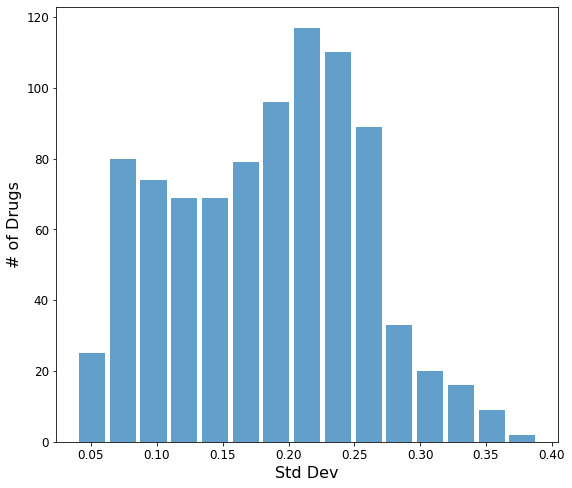

In [11]:
stddev_map = calc_stddev(drug_list, all_df, 'smiles')
av_drug_hist = create_bar_plot(stddev_map.values(), 'Std Dev', '# of Drugs')

In [12]:
std_vals = np.array(list(stddev_map.values()))

In [13]:
threshold = np.median(std_vals) + 1.5*np.std(std_vals)
threshold

0.2991595383519319

In [14]:
top_drugs = []
for i, drug in enumerate(stddev_map.keys()):
    if i == 50:
        break
    top_drugs.append(drug)

top_drugs = [drug_smiles_map[d] for d in top_drugs if '.' not in d]

In [17]:
top_drugs

['Ursolic-acid',
 'Crizotinib',
 'N-[4-(1-BENZOYLPIPERIDIN-4-YL)BUTYL]-3-PYRIDIN-3-YLPROPANAMIDE',
 'parthenolide',
 'Salermide',
 '200484-11-3',
 'BRD6708',
 'BRD-K41087962-001-01-7',
 'PIK-75',
 'ML-210',
 'importazole',
 'Panduratin-A',
 'Daporinad',
 '67200-34-4',
 'Bosutinib',
 'AM580',
 'STF-31',
 'IDARUBICIN',
 'ethyl-5,5,7,7-tetramethyl-2-(5-nitrothiophene-2-carboxamido)-4,5,6,7-tetrahydrothieno[2,3-c]pyridine-3-carboxylate',
 'Dasatinib',
 'Austocystin-D',
 'Ro-28-1675',
 'AZD5991',
 'paclitaxel',
 'Aacocf3',
 'CD-1530',
 'ERASTIN',
 'CHEBI:94110',
 'prima-1',
 'RITA',
 'methotrexate',
 'Compound-10b',
 'Afatinib',
 'SpOx1_002925',
 'Manumycin-A',
 'Silmitasertib',
 'ml320',
 'GPP78',
 '1170689-68-5',
 'Navitoclax',
 'GW843682X',
 'Canertinib',
 'CI-976']

In [16]:
top_drugs_df = pd.DataFrame(top_drugs)

In [ ]:
#top_drugs_df.to_csv("../data/training_files_av/drugname_av.txt", header=False, index=False)

In [ ]:
#drugs = ["Palbociclib", "nutlin-3A", "Trametinib", "Dabrafenib", "Rapamycin", "Olaparib", "etoposide"]
drugs = ['Palbociclib']
create_select_drug_data(cell_list, drugs, drug_name_map, all_df, dataset)